# Importing and constructing our pre-processing function

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer # Vectorizers
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix,accuracy_score # Evaluation metrics

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.stem.porter import PorterStemmer

def preProcess(text):
    ps = PorterStemmer()
#     wordnet=WordNetLemmatizer()
    text = re.sub('https?://\S+|www\.\S+', '', text) # removes any URLs
    sentences = nltk.sent_tokenize(text)
    corpus = []
    for i in range(len(sentences)):
        sentence = re.sub('[^a-zA-Z]', ' ', sentences[i]) #substitute all characters except alphabets with ' '
        sentence = sentence.lower() #Lower all characters in the sentence
        sentence = sentence.split() # Convert the sentence into list of words so we apply lemmatization.
        #Lemmatizing non stopwords and removing stopwords
        sentence = [ps.stem(word) for word in sentence if not word in set(stopwords.words('english'))] 
        sentence = ' '.join(sentence) # Turn it back into a sentence
        corpus.append(sentence) # This will result into an array of sentences as it's elements
    result = " ".join(corpus)
    return result



## Loading the datasets

In [14]:
import pandas as pd

# Load the dataset
dataset = pd.read_csv('stemmed_WELFake_70k.csv')
pd.options.mode.chained_assignment = None
# dataset = dataset[dataset['lemma_text'].astype(str).apply(lambda x: len(x.strip()) > 0)]

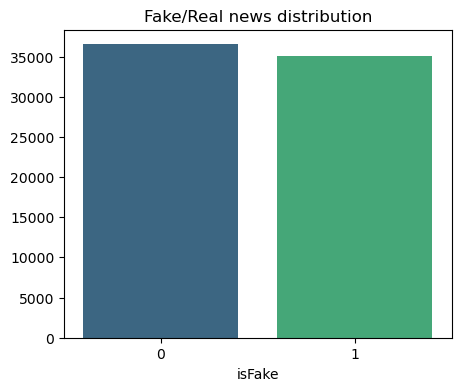

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each class label
class_counts = dataset['isFake'].value_counts()

# Plot the counts using seaborn
plt.figure(figsize=(5, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Fake/Real news distribution')
plt.xlabel('isFake')
plt.show()


## Checking for NaN values 

In [16]:
dataset.isna().sum()

Unnamed: 0      0
title           0
text            0
label           0
isFake          0
lemma_text    748
dtype: int64

## Removing NaN values if there's any 

In [17]:
dataset = dataset.dropna() #Remove all records with NaN values

In [18]:
dataset.isna().sum()

Unnamed: 0    0
title         0
text          0
label         0
isFake        0
lemma_text    0
dtype: int64

## Reseting the indexes, since we deleted NaN values

In [19]:
dataset.reset_index(drop=True, inplace=True)

### Adding a column "isFake" to be consistent with the other dataset ( 1 = FAKE, 0 = REAL)

In [20]:
dataset["isFake"] = dataset["label"].apply(lambda x: 0 if (x == "REAL" or x == 1) else 1)

In [21]:
dataset

,Unnamed: 0,title,text,label,isFake,lemma_text
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,0,comment expect barack obama member fyf fukyofl...
1,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,0,demonstr gather last night exercis constitut p...
2,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,1,dozen polit activ pastor came privat dinner fr...
3,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,0,rs sarmat missil dub satan replac ss fli mile ...
4,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,0,say one time someon su southern poverti law ce...
...,...,...,...,...,...,...
70784,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,1,washington reuter hacker believ work russian g...
70785,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,0,know fantasyland republican never question cit...
70786,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,1,migrant refus leav train refuge camp hungari t...
70787,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0,1,mexico citi reuter donald trump comb style buf...


### Essential step : Processing the text and stemming it. We already did that and saved it into a file to save time :)

In [22]:
# dataset["lemma_text"] = dataset["text"].apply(preProcess)

## Splitting data and vectorizing it

In [23]:
train_set, temp_set = train_test_split(dataset, test_size=0.3, random_state=42) # 70% -> train , 30% temp_set
valid_set, test_set = train_test_split(temp_set, test_size=0.33, random_state=42) # (20% of entire data) validation, 10% test
test_set.reset_index(drop=True, inplace=True) # resetting indexes for the test function
valid_set.reset_index(drop=True, inplace=True)

# Vectorizer part
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,2)) # We can switch between CountVectorizer and TfidfVectorizer
X_train = vectorizer.fit_transform(train_set['lemma_text'])
X_valid = vectorizer.transform(valid_set['lemma_text'])
X_test = vectorizer.transform(test_set['lemma_text'])


In [24]:
X_train.shape

(49552, 5000)

# First method : Deep Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Converting labels to PyTorch tensors for our model
y_train = torch.tensor(train_set['isFake'].values, dtype=torch.float32)
y_valid = torch.tensor(valid_set['isFake'].values, dtype=torch.float32)
y_test = torch.tensor(test_set['isFake'].values, dtype=torch.float32)

# Create DataLoader for training, validation, and testing sets
train_dataset = TensorDataset(torch.tensor(X_train.toarray(), dtype=torch.float32), y_train)
valid_dataset = TensorDataset(torch.tensor(X_valid.toarray(), dtype=torch.float32), y_valid)
test_dataset = TensorDataset(torch.tensor(X_test.toarray(), dtype=torch.float32), y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# hyperparameters
input_size = X_train.shape[1]

h1_size = 64 #hiddel layer sizes
h2_size = 32

output_size = 1
learning_rate = 1e-3

#dropout probability
dropout_p=0.4

class Network(nn.Module):
    def __init__(self, input_size, h1_size, h2_size, output_size, dropout_prob):
        super(Network, self).__init__()
        self.linear1 = nn.Linear(input_size, h1_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)

        self.linear2 = nn.Linear(h1_size, h2_size)
        #relu
        #droput
        self.linear3 = nn.Linear(h2_size, output_size)
        #sigmoid

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.linear3(x)
        y_pred = torch.sigmoid(x)
        return y_pred


model = Network(input_size, h1_size, h2_size, output_size, dropout_p)

# Initialize the loss function and optimizer
criterion = nn.BCELoss() # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(),learning_rate)

# Training phase
'''
epoch = 1 means forward and backward pass of all training samples
batch_size = number of training samples in one FP and BP. It's a hyperparam, we control it in Dataloaders
'''
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.5f}')

    
model.eval() # We set it up before validation/testing to turn dropout off

# Validation phase
with torch.no_grad():
    correct = 0
    total = 0
    valid_predictions = []
    for inputs, labels in valid_loader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels.view(-1, 1)).sum().item()
        valid_predictions.extend(predicted.int().tolist())

valid_accuracy = correct / total
valid_precision = precision_score(y_valid.numpy(), valid_predictions)
valid_recall = recall_score(y_valid.numpy(), valid_predictions)
valid_f1 = f1_score(y_valid.numpy(), valid_predictions)
conf_matrix_valid = confusion_matrix(y_valid.numpy(), valid_predictions)

print(f'Confusion Matrix (Validation):\n{conf_matrix_valid}')
print(f'Validation Accuracy: {valid_accuracy:.2%}')
print(f'Validation Precision: {valid_precision:.2%}')
print(f'Validation Recall: {valid_recall:.2%}')
print(f'Validation F1 Score: {valid_f1:.2%}')

Epoch [1/10], Loss: 0.10714
Epoch [2/10], Loss: 0.18588


### My Custom made testing function  

In [ ]:
def classify_text(raw_text, model, vectorizer):
    vectorized_text = vectorizer.transform([raw_text]) # Vectorize the raw text
    input_tensor = torch.tensor(vectorized_text.toarray(), dtype=torch.float32) # Convert to PyTorch tensor
    model.eval() # Set the model to evaluation mode
    
    # Forward pass through the model
    with torch.no_grad():
        output = model(input_tensor)
    
    #Classifying part, if > 0.5 then fake, otherwise it's true
    predicted_label = (output > 0.5).float().item()
    if predicted_label == 1:
        label = 1 #Fake
    elif predicted_label == 0:
        label = 0 # REAL
    return label

# Testing loop
correct = 0
test_predictions = []

for i in range(len(test_set)):
    outcome = classify_text(test_set["lemma_text"][i], model, vectorizer)
    test_predictions.append(outcome)
    
#     print(f'Predicted outcome = {outcome}\tActual Outcome = {test_set["isFake"][i]}')
    
    # If comparison holds, increment correct
    if outcome == test_set["isFake"][i]:
        correct += 1

# Calculate Metrics
test_accuracy = correct / len(test_set)
test_precision = precision_score(y_test.numpy(), test_predictions)
test_recall = recall_score(y_test.numpy(), test_predictions)
test_f1 = f1_score(y_test.numpy(), test_predictions)

print(f"{correct} Out of {len(test_set)}")
print(f'Network Accuracy: {test_accuracy:.2%}')
print(f'Network Precision: {test_precision:.2%}')
print(f'Network Recall: {test_recall:.2%}')
print(f'Network F1 Score: {test_f1:.2%}')

network_conf_matrix_test = confusion_matrix(y_test.numpy(), test_predictions)
print(f'Confusion Matrix (Test):\n{network_conf_matrix_test}')


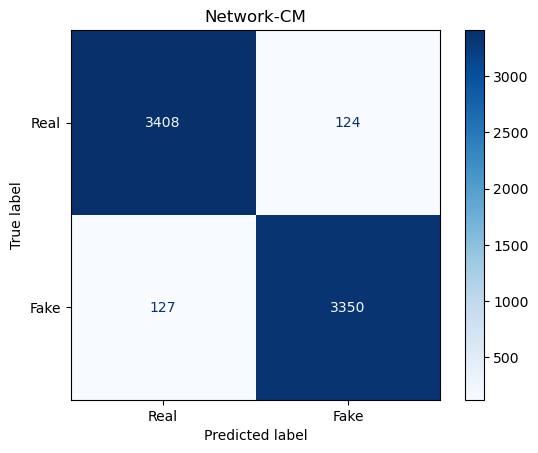

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Display confusion matrix
disp = ConfusionMatrixDisplay(network_conf_matrix_test, display_labels=['Real', 'Fake'])
disp.plot(cmap=plt.cm.Blues, values_format='.0f')
plt.title('Network-CM')
plt.show()

# Second Method : SVM Classifier

In [ ]:
# Extracting labels (target variable) for the training set
y_train = train_set['isFake'].values

# Extracting labels (target variable) for the validation set
y_valid = valid_set['isFake'].values

# Extracting labels (target variable) for the test set
y_test = test_set['isFake'].values


from sklearn.svm import SVC
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

valid_predictions = svm_model.predict(X_valid)
val_accuracy = accuracy_score(y_valid, valid_predictions)

test_predictions = svm_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
val_accuracy_percentage = val_accuracy * 100
print("Validation Accuracy: {:.2f}%\n".format(val_accuracy_percentage))

In [ ]:

test_accuracy_percentage = test_accuracy * 100
#We finalize here, and display the result and performance of our task:
svm_precision = precision_score(y_test, test_predictions)
svm_recall = recall_score(y_test, test_predictions)
svm_f1 = f1_score(y_test, test_predictions)

print("SVM Accuracy: {:.2f}%".format(test_accuracy_percentage))
print(f'SVM Precision: {svm_precision:.2%}')
print(f'SVM Recall: {svm_recall:.2%}')
print(f'SVM F1 Score: {svm_f1:.2%}')

svm_conf_matrix_test = confusion_matrix(y_test, test_predictions)
print(f'Confusion Matrix (Test):\n{svm_conf_matrix_test}')

In [ ]:
# Display confusion matrix
disp = ConfusionMatrixDisplay(svm_conf_matrix_test, display_labels=['Real', 'Fake'])
disp.plot(cmap=plt.cm.Blues, values_format='.0f')
plt.title('SVM-CM')
plt.show()

# Third Method : Ensemble Model

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# We have already preprocessed our data and all. We will be using the isFake column from here on

# Extracting labels (target variable) for the training set
y_train = train_set['isFake'].values

# Extracting labels (target variable) for the validation set
y_valid = valid_set['isFake'].values

# Extracting labels (target variable) for the test set
y_test = test_set['isFake'].values


# Here we are implementing RandomForestEnsemble with bootstrapped sampling
class RandomForestEnsemble:
    def __init__(self, base_classifier, n_classifiers=6):
        # Initialize the ensemble with a base classifier and the number of classifiers
        self.base_classifier = base_classifier
        self.n_classifiers = n_classifiers
        # Create a list to store individual classifiers
        self.classifiers = [base_classifier.__class__() for _ in range(n_classifiers)]

    def fit(self, X, y, dataset_name, debug=False):
        # Iterate over the classifiers and fit each with a bootstrapped sample
        for i, classifier in enumerate(self.classifiers):
            # Generate random indices for bootstrapped sampling
            indices = np.random.choice(len(X), len(X), replace=True)
            X_bootstrap, y_bootstrap = X[indices], y[indices]

            if debug:
                print(f'Fitting classifier {i} for {dataset_name} with bootstrap sample shape: '
                      f'({X_bootstrap.shape[0]} samples (rows), {X_bootstrap.shape[1]} features (columns))')

            if X_bootstrap.shape[0] == 0:
                raise ValueError(f"Empty bootstrap sample for classifier {i}")

            # Fit the classifier with the bootstrapped sample
            classifier.fit(X_bootstrap, y_bootstrap)

            if debug:
                print(f'Finished fitting classifier {i}')

    def predict(self, X, threshold=0.5):
        # Make predictions for each classifier and combine them
        predictions = np.zeros((len(self.classifiers), X.shape[0]))
        for i, classifier in enumerate(self.classifiers):
            predictions[i, :] = classifier.predict_proba(X)[:, 1]
        final_predictions = np.mean(predictions, axis=0)
        # Apply a threshold to obtain binary predictions
        binary_predictions = (final_predictions > threshold).astype(int)
        return binary_predictions


# Instantiating our base classifier
base_classifier_rf = RandomForestClassifier(n_estimators=50)
ensemble_rf = RandomForestEnsemble(base_classifier_rf, n_classifiers=6)

# Fitting ensemble on our training data
ensemble_rf.fit(X_train.toarray(), y_train, dataset_name="Training Set", debug=True)

# Validations process
predictions_valid_rf = ensemble_rf.predict(X_valid.toarray())
accuracy_valid_rf = accuracy_score(y_valid, predictions_valid_rf, normalize=True)  # Ensure normalize=True for percentage
validation_accuracy_percentage = accuracy_valid_rf * 100
print(f'Validation Accuracy: {validation_accuracy_percentage:.2f}%\n')

# Predictions are made on the test set, and the accuracy is calculated and printed.
predictions_test_rf = ensemble_rf.predict(X_test.toarray())
accuracy_test_rf = accuracy_score(y_test, predictions_test_rf)
test_accuracy_percentage = accuracy_test_rf * 100

test_precision_percentage = precision_score(y_test, predictions_test_rf)
test_recall_percentage = recall_score(y_test, predictions_test_rf)
test_f1_percentage = f1_score(y_test, predictions_test_rf)

print(f'Test Accuracy: {test_accuracy_percentage:.2f}%')
print(f'Ensemble Precision: {test_precision_percentage:.2%}')
print(f'Ensemble Recall: {test_recall_percentage:.2%}')
print(f'Ensemble F1 Score: {test_f1_percentage:.2%}')

rf_conf_matrix_test = confusion_matrix(y_test, predictions_test_rf)
print(f'Confusion Matrix (Test):\n{rf_conf_matrix_test}')




In [ ]:
# Display confusion matrix
disp = ConfusionMatrixDisplay(rf_conf_matrix_test, display_labels=['Real', 'Fake'])
disp.plot(cmap=plt.cm.Blues, values_format='.0f')
plt.title('Random Forest-CM')
plt.show()